In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# For feature importance (model-dependent and permutation-based)
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')  # To suppress warnings if desired


In [2]:
# E.g., reading from CSV – adapt to your actual file names or data sources
df_Kiwi = pd.read_csv("flight_data_kiwi_allsnaps_clean.csv")
df_Momondo = pd.read_csv("flight_data_momondo_All_combined_Cloud.csv")
# Clean the 'Price' column: Remove any non-digit characters and convert to float
df_Kiwi['Price'] = df_Kiwi['Price'].str.extract('(\d+)', expand=False).astype(float)

# Check if there are any null values in the 'Price' column
print(df_Kiwi.isnull().sum())


Snap Date        0
Dep Date         0
Return Date      0
Outbound         0
Dep Time         0
Dep Duration     0
Dep Arrival      0
From             0
Stops            0
Landing          0
Inbound          0
Back Time        0
Back Duration    0
Back Arrival     0
From.1           0
Stops.1          0
Landing.1        0
Dep Company      0
Back Company     0
Price            0
dtype: int64


In [3]:
print(df_Kiwi.info())
print(df_Kiwi.describe())
print(df_Kiwi.isnull().sum())
# ... similarly for df_Momondo


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271981 entries, 0 to 271980
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Snap Date      271981 non-null  object 
 1   Dep Date       271981 non-null  object 
 2   Return Date    271981 non-null  object 
 3   Outbound       271981 non-null  object 
 4   Dep Time       271981 non-null  object 
 5   Dep Duration   271981 non-null  object 
 6   Dep Arrival    271981 non-null  object 
 7   From           271981 non-null  object 
 8   Stops          271981 non-null  int64  
 9   Landing        271981 non-null  object 
 10  Inbound        271981 non-null  object 
 11  Back Time      271981 non-null  object 
 12  Back Duration  271981 non-null  object 
 13  Back Arrival   271981 non-null  object 
 14  From.1         271981 non-null  object 
 15  Stops.1        271981 non-null  int64  
 16  Landing.1      271981 non-null  object 
 17  Dep Company    271981 non-nul

In [4]:
print(df_Momondo.info())
print(df_Momondo.describe())
print(df_Momondo.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281927 entries, 0 to 281926
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Snap Date                      281927 non-null  object
 1   Dep Date                       281927 non-null  object
 2   Return Date                    281927 non-null  object
 3   Dep time                       281927 non-null  object
 4   Dep Company                    281927 non-null  object
 5   Stops                          281927 non-null  object
 6   Dep Duration                   281927 non-null  object
 7   From Airport                   281927 non-null  object
 8   Landing Airport                281927 non-null  object
 9   Back Time                      281927 non-null  object
 10  Back Company                   281927 non-null  object
 11  Stops.1                        281927 non-null  object
 12  Back Duration                  281927 non-nu

In [5]:
def create_additional_features(df):
    # From columns: 'Dep Date', 'Return Date', 'Snap Date'
    # We convert them to datetime:
    df['Dep Date'] = pd.to_datetime(df['Dep Date'])
    df['Return Date'] = pd.to_datetime(df['Return Date'])
    df['Snap Date'] = pd.to_datetime(df['Snap Date'])

    # Day of week (Monday=0, Sunday=6)
    df['outbound_dayofweek'] = df['Dep Date'].dt.dayofweek
    df['return_dayofweek'] = df['Return Date'].dt.dayofweek

    # Proximity to month-end
    df['outbound_day'] = df['Dep Date'].dt.day
    df['return_day'] = df['Return Date'].dt.day

    # TTT (Time to Travel): difference in days between Snap Date and Dep Date
    df['TTT'] = (df['Dep Date'] - df['Snap Date']).dt.days

    # LOS (Length of Stay): diference in nights between Dep Date and Return Date
    df['LOS'] = (df['Return Date'] - df['Dep Date']).dt.days

    # Example: Interaction feature
    df['TTT_LOS_interaction'] = df['TTT'] * df['LOS']

    # We drop any rows with negative or invalid TTT/LOS if they appear (just in case...)
    df = df[df['TTT'] >= 0]
    df = df[df['LOS'] > 0]

    # Return the updated dataframe
    return df

df_Kiwi = create_additional_features(df_Kiwi)
df_Momondo = create_additional_features(df_Momondo)


In [6]:
#Train-Test Split (Step 3.2)
features = [
    'TTT', 'LOS', 'outbound_dayofweek', 'return_dayofweek',
    'outbound_day', 'return_day', 'TTT_LOS_interaction'
]
target = 'Price'  # adapt if your Price column is named differently

X_site1 = df_Kiwi[features].copy()
y_site1 = df_Kiwi[target].copy()

X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(
    X_site1, y_site1, test_size=0.3, random_state=42
)


In [7]:
#Experiment with Different Normalization Methods (Step 3.8)
scalers = {
    'none': None,
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler()
}
def scale_data(X_train, X_test, scaler):
    if scaler is None:
        return X_train, X_test
    else:
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

In [8]:
#Evaluation Function & Residual Plot (Steps 3.5 & 3.6)
def evaluate_model(model_name, model, y_train, y_pred_train, y_test, y_pred_test, scaler_name=None):
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    # Residual plot
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred_train, y_train - y_pred_train, alpha=0.5, label='Train')
    plt.scatter(y_pred_test, y_test - y_pred_test, alpha=0.5, label='Test')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name} [Scaler={scaler_name}]')
    plt.legend()
    plt.show()

    return {
        'Model': model_name,
        'Scaler': scaler_name,
        'MSE_Train': mse_train,
        'MSE_Test': mse_test,
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'MAE_Train': mae_train,
        'MAE_Test': mae_test,
        'R2_Train': r2_train,
        'R2_Test': r2_test
    }

In [28]:
#Regression Algorithms (Step 3.1, 3.3)
def train_and_evaluate_models(X_train, X_test, y_train, y_test, scaler_name=None):
    results = []

    # 1) LinearRegression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)

    results.append(
        evaluate_model("LinearRegression", lr, y_train, y_pred_train, y_test, y_pred_test, scaler_name)
    )

    # 2) DecisionTreeRegressor
    # Example of a small param grid; you can expand
    for depth in [3, 5, 7]:
        dt = DecisionTreeRegressor(max_depth=depth, random_state=42)
        dt.fit(X_train, y_train)
        y_pred_train = dt.predict(X_train)
        y_pred_test = dt.predict(X_test)

        results.append(
            evaluate_model(f"DecisionTree(d={depth})", dt, y_train, y_pred_train, y_test, y_pred_test, scaler_name)
        )

    # 3) GaussianProcessRegressor
    # Example: try different kernels
    max_gpr_samples = 5000
    
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    sample_indices = np.random.choice(len(X_train), max_gpr_samples, replace=False)
    X_train_gpr = X_train.loc[sample_indices]  # Now these are valid row labels
    y_train_gpr = y_train.loc[sample_indices]


    kernels = [
        DotProduct() + WhiteKernel(),
        RBF(length_scale=1.0) + WhiteKernel()
    ]
    for kernel in kernels:
        gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)
        gpr.fit(X_train_gpr, y_train_gpr)  # Fit on the small subset
        y_pred_train = gpr.predict(X_train_gpr)
        y_pred_test = gpr.predict(X_test)   # Evaluate on the full test set
        results.append(
            evaluate_model(f"GPR({kernel})", gpr, y_train_gpr, y_pred_train, y_test, y_pred_test, scaler_name)
        )

    # 4) RandomForestRegressor
    # Just an example; you could do a loop or GridSearch
    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    results.append(
        evaluate_model("RandomForest", rf, y_train, rf.predict(X_train), y_test, rf.predict(X_test), scaler_name)
    )

    # 5) KNeighborsRegressor
    for k in [3, 5, 7]:
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        results.append(
            evaluate_model(f"KNN(k={k})", knn, y_train, knn.predict(X_train), y_test, knn.predict(X_test), scaler_name)
        )

    # 6) GradientBoostingRegressor
    gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbr.fit(X_train, y_train)
    results.append(
        evaluate_model("GBR", gbr, y_train, gbr.predict(X_train), y_test, gbr.predict(X_test), scaler_name)
    )

    return pd.DataFrame(results)


TTT: 0.3531
LOS: 0.0185
outbound_dayofweek: 0.3120
return_dayofweek: 0.2025
outbound_day: 0.0657
return_day: 0.0062
TTT_LOS_interaction: 0.0421


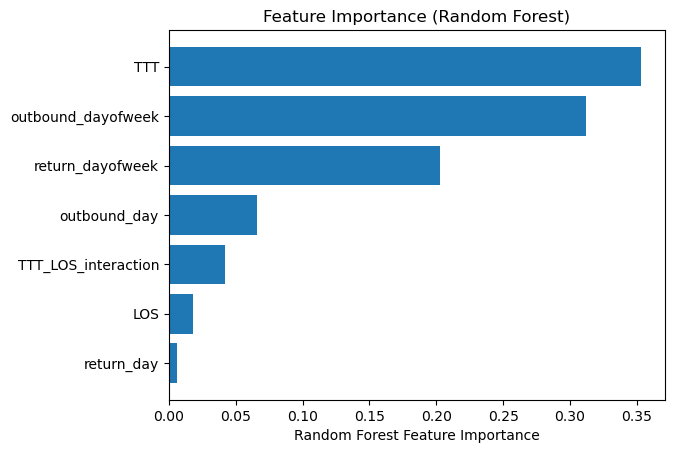

In [24]:
#Feature Importance (Step 3.5)
# Model-Based
# Decision Tree / Random Forest / Gradient Boosting
# 1. Train a RandomForestRegressor on your data
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train_s1, y_train_s1)

# 2. Access feature_importances_
if hasattr(rf, 'feature_importances_'):
    importances = rf.feature_importances_
    
    # 3. Print or plot them
    for f, imp in zip(features, importances):
        print(f"{f}: {imp:.4f}")

    # (Optional) Visualize
    import matplotlib.pyplot as plt
    import numpy as np

    indices = np.argsort(importances)
    plt.barh([features[i] for i in indices], importances[indices])
    plt.xlabel("Random Forest Feature Importance")
    plt.title("Feature Importance (Random Forest)")
    plt.show()

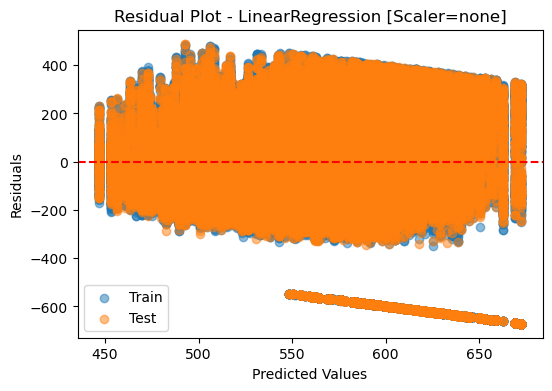

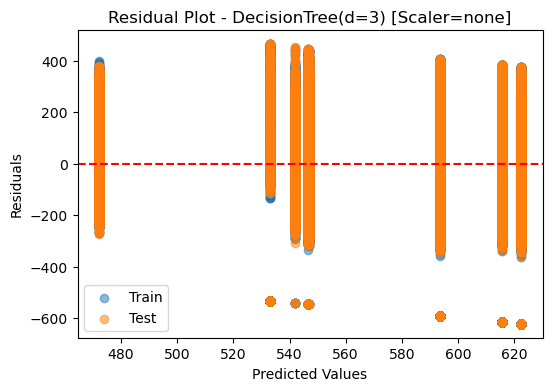

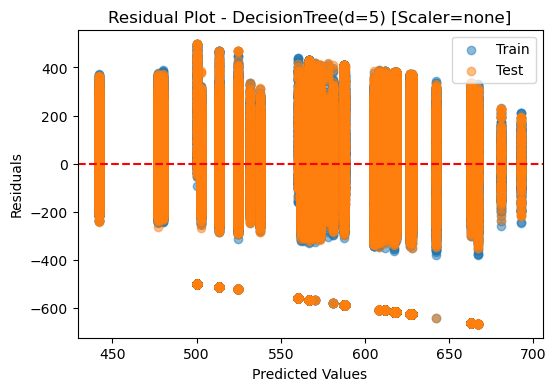

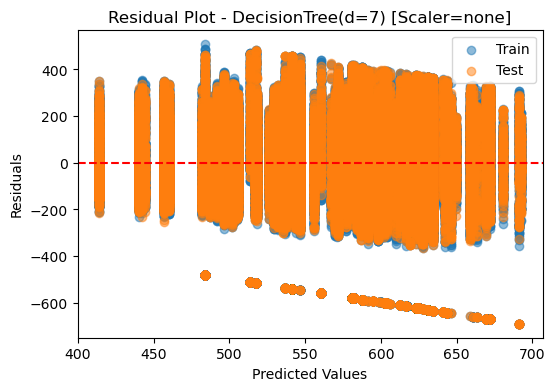

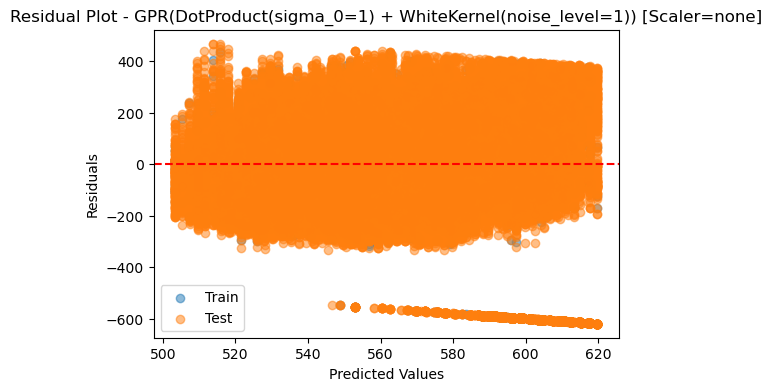

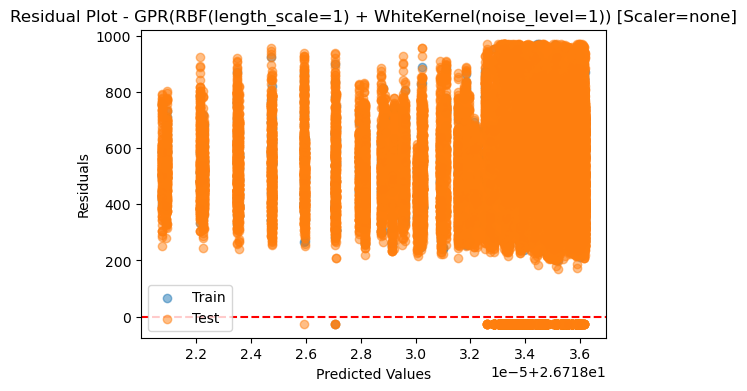

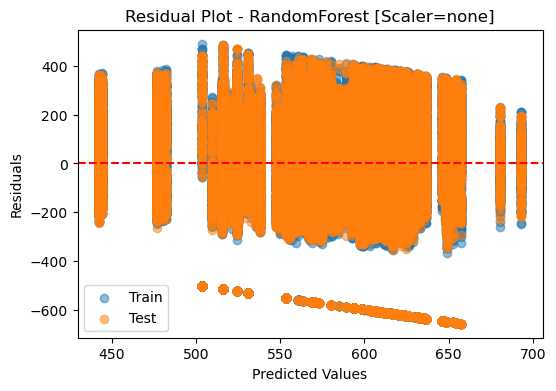

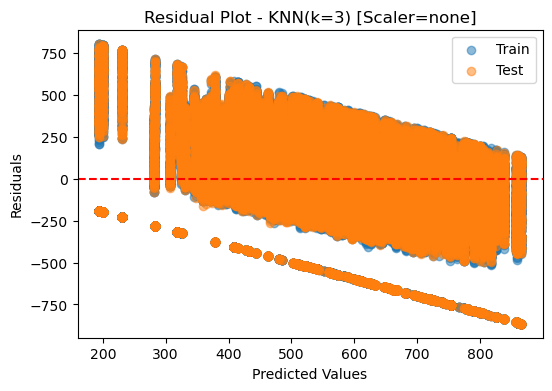

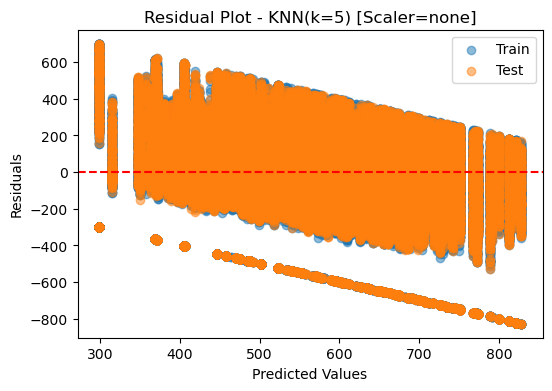

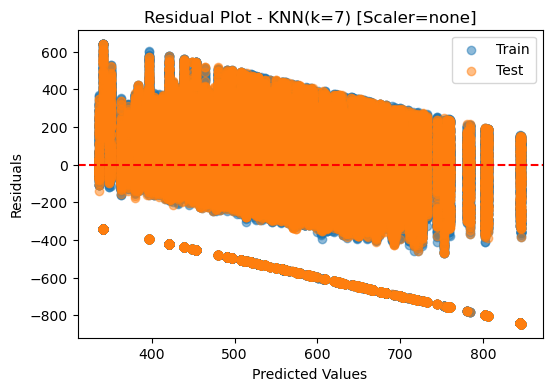

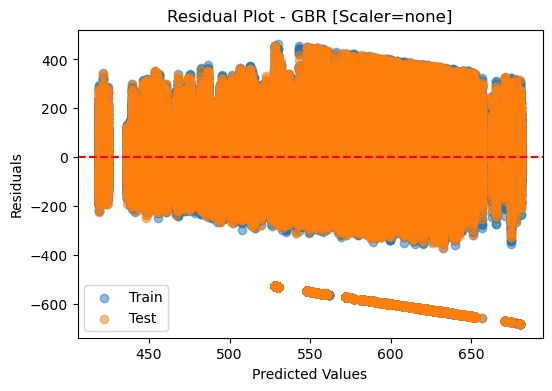

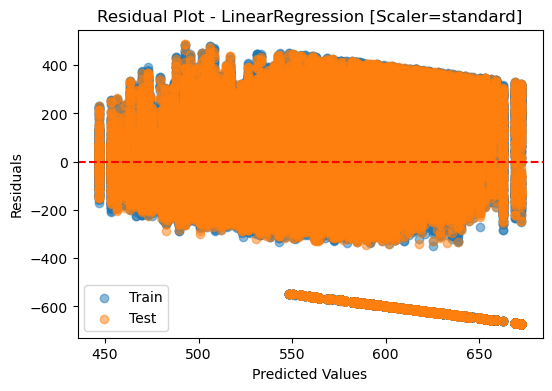

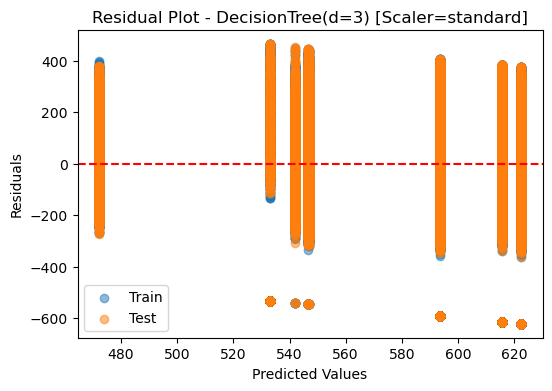

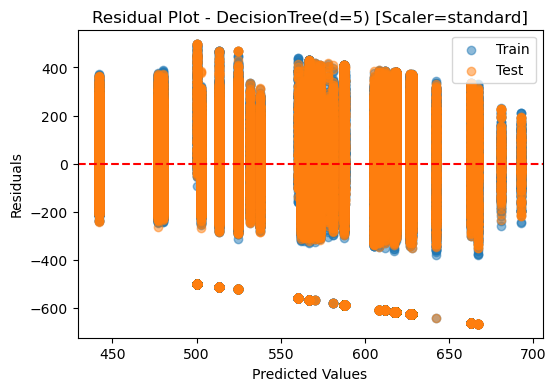

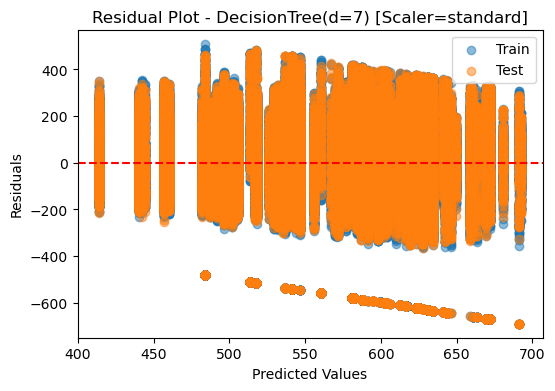

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

In [29]:
#Running Everything for Kiwi and Momondo (Step 3.9)
all_results_site1 = pd.DataFrame()

for scaler_name, scaler_obj in scalers.items():
    X_train_scaled, X_test_scaled = scale_data(X_train_s1, X_test_s1, scaler_obj)
    results_df = train_and_evaluate_models(
        X_train_scaled, X_test_scaled,
        y_train_s1, y_test_s1,
        scaler_name=scaler_name
    )
    all_results_site1 = pd.concat([all_results_site1, results_df], ignore_index=True)

# Sort or group by best R2_Test or lowest RMSE_Test, etc.
all_results_site1.sort_values(by='R2_Test', ascending=False)


In [ ]:
#Analyzing the Distribution of R² Errors (Step 3.10)
# Suppose your dataset has columns: 'flight_id' or something that identifies unique flights
best_model = ...  # your chosen best model
X_test = ...
y_test = ...

y_pred_test = best_model.predict(X_test)

# Calculate R2 per flight_id
df_test_results = pd.DataFrame({
    'flight_id': df_Kiwi.loc[X_test.index, 'flight_id'],
    'actual': y_test,
    'pred': y_pred_test
})
r2_by_flight = df_test_results.groupby('flight_id').apply(
    lambda g: r2_score(g['actual'], g['pred'])
)

plt.figure(figsize=(8,4))
sns.histplot(r2_by_flight, kde=True)
plt.title("Distribution of R2 across different flights")
plt.xlabel("R2")
plt.ylabel("Count")
plt.show()

In [ ]:
#Future-Oriented Train/Test Split (Step 3.11)
df_train_future = df_Kiwi[df_Kiwi['TTT'] <= 25]
df_test_future  = df_Kiwi[df_Kiwi['TTT'] > 25]

X_train_future = df_train_future[features]
y_train_future = df_train_future[target]

X_test_future = df_test_future[features]
y_test_future = df_test_future[target]

# Possibly scale again
X_train_future_scaled, X_test_future_scaled = scale_data(X_train_future, X_test_future, StandardScaler())

# Fit best model from earlier or retrain a new one:
best_model_future = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
best_model_future.fit(X_train_future_scaled, y_train_future)

y_pred_future = best_model_future.predict(X_test_future_scaled)

# Compute metrics
mse_future = mean_squared_error(y_test_future, y_pred_future)
rmse_future = np.sqrt(mse_future)
r2_future = r2_score(y_test_future, y_pred_future)
print("Future Split Results:")
print(f"MSE: {mse_future}, RMSE: {rmse_future}, R2: {r2_future}")
